In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import accuracy_score, roc_curve


In [4]:
# Import data and split into train/test sets
news_df = pd.read_csv('../data/news_classification.csv')
xFeat = news_df.drop('high_popularity', axis=1)
y = news_df['high_popularity']
xTrain, xTest, yTrain, yTest = train_test_split(xFeat, y, test_size=0.3, random_state=42)

In [5]:
# Baseline model accuracies
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
]

accuracies = []
for model in models:
    model.fit(xTrain, yTrain)
    y_pred = model.predict(xTest)
    accuracy = accuracy_score(yTest, y_pred)
    accuracies.append((model.__class__.__name__, accuracy))

for model_name, accuracy in accuracies:
    print(f"{model_name}: {accuracy}")

RandomForestClassifier: 0.6961352198271769
GradientBoostingClassifier: 0.7119931630424461
AdaBoostClassifier: 0.7040167125629095


In [6]:
# Default values, overwrite with tuned values validated with GridSearchCV
best_learning_rate = 0.1
best_n_estimators = 100
best_estimator = DecisionTreeClassifier(max_depth = 1)

In [7]:
# Tune learning rate
learning_rate_params = {
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
}

model = AdaBoostClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, estimator=best_estimator)
grid = GridSearchCV(model, learning_rate_params, cv = 5, scoring='accuracy')
grid.fit(xTrain, yTrain)

best_learning_rate = grid.best_params_['learning_rate']
print('Best Learning Rate: ', grid.best_params_)
print('Best AUC Score: ', grid.best_score_)

Best Learning Rate:  {'learning_rate': 0.1}
Best AUC Score:  0.6944082946931369


In [16]:
# Tune n estimators
n_estimators_params = {
    'n_estimators': [3, 5, 10, 20, 30, 50, 100],
}

model = AdaBoostClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, estimator=best_estimator)
grid = GridSearchCV(model, n_estimators_params, cv = 5, scoring='accuracy')
grid.fit(xTrain, yTrain)

best_n_estimators = grid.best_params_['n_estimators']
print('Best N Estimators: ', grid.best_params_)
print('Best AUC Score: ', grid.best_score_)

Best N Estimators:  {'n_estimators': 100}
Best AUC Score:  0.6944082946931369


In [24]:
# Tune n estimators
max_depth_values = [3, 5, 7, 10, 15, 20]
estimator_params = {
    'estimator': [DecisionTreeClassifier(max_depth=depth) for depth in max_depth_values]
}

model = AdaBoostClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, estimator=best_estimator)
grid = GridSearchCV(model, estimator_params, cv = 5, scoring='accuracy')
grid.fit(xTrain, yTrain)

best_estimator = grid.best_params_['estimator']
print('Best Estimator Model: ', grid.best_params_)
print('Best AUC Score: ', grid.best_score_)

Best Estimator Model:  {'estimator': DecisionTreeClassifier(max_depth=3)}
Best AUC Score:  0.708407858295956


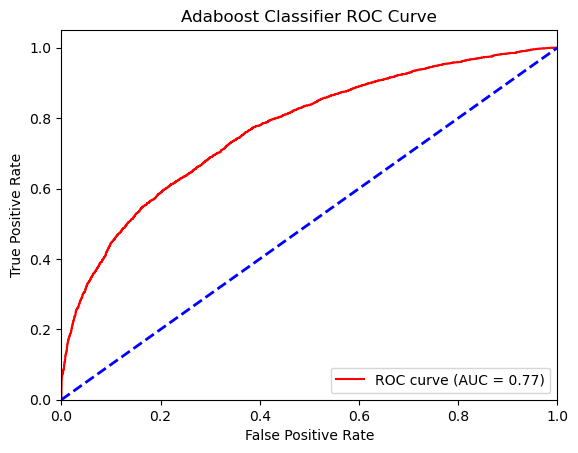

Best Learning Rate: 0.1
Best N Estimators: 100
Best Estimator Max Depth: DecisionTreeClassifier(max_depth=3)
Accuracy: 0.7126578672490742
Error: 0.28734213275092585
AUC: 0.7690325525794168


In [23]:
# Final hypertuned model
model = AdaBoostClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, estimator=best_estimator)
model.fit(xTrain, yTrain)
yHat = model.predict(xTest)

error = np.mean(yHat != yTest)
accuracy = accuracy_score(yTest, yHat)

# ROC curve and AUC
yHat_prob = model.predict_proba(xTest)[:, 1]
fpr, tpr, thresholds = roc_curve(yTest, yHat_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaboost Classifier ROC Curve')
plt.legend(loc='lower right')
plt.savefig('adaboost_final_roc.png')
plt.show()

print(f'Best Learning Rate: {best_learning_rate}')
print(f'Best N Estimators: {best_n_estimators}')
print(f'Best Estimator Max Depth: {best_estimator}')
print(f'Accuracy: {accuracy}')
print(f'Error: {error}')
print(f'AUC: {roc_auc}')